# Housing Data Project


### Collecting Data
First we need to collect the data.  Download and extract it.   

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH  = "datasets/housing"
HOUSING_URL   = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data( housing_url=HOUSING_URL, housing_path=HOUSING_PATH ):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve( housing_url, tgz_path )
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

### Reading Data
We read the data into a pandas data object.  These objects have lots of convienence functions defined on them to quickly manipulate their underlying dataset.  Saves a lot of time.  

In [2]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

For instance, we can quickly view the top few rows of data with the head method. 

In [3]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Individual fields can be inspected with array notation.  The returned object itself has convience methods defined.  For example, we can see the individual values, or range, of the ocean_proximity field:

In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


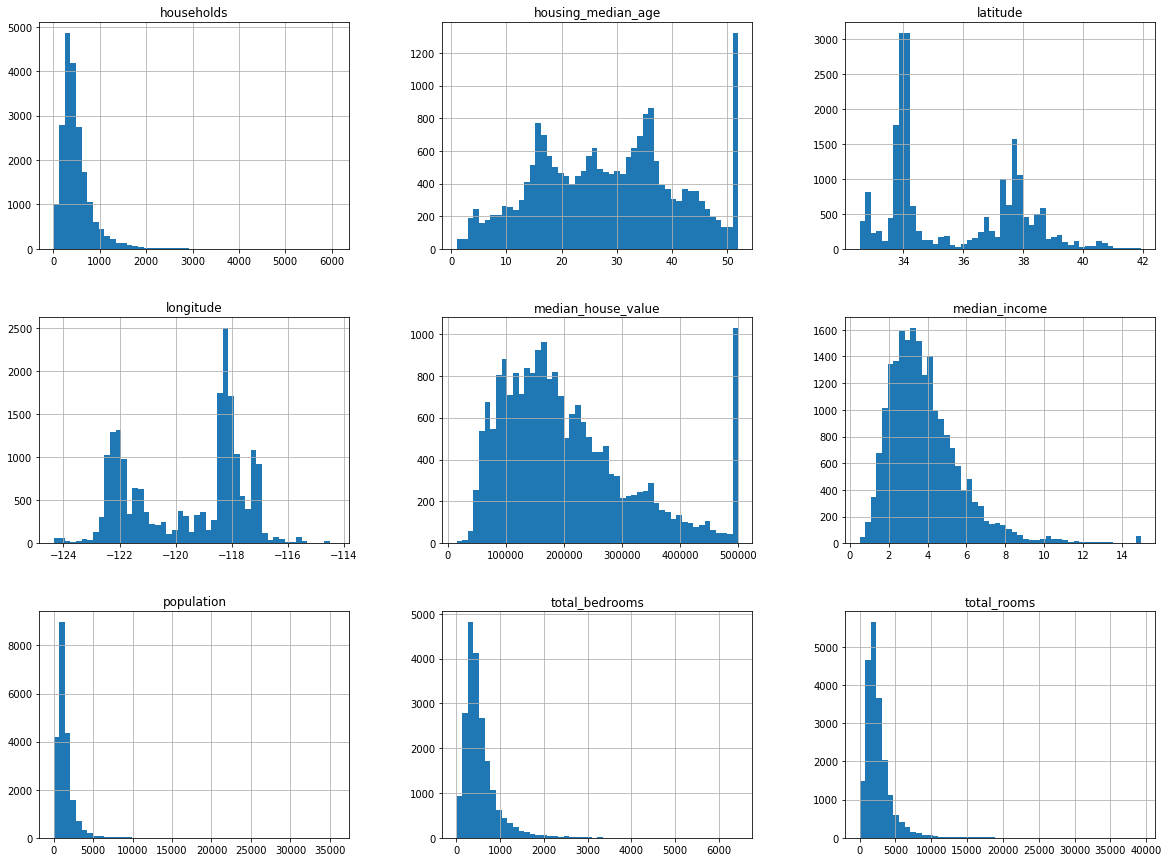

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

## Create Test Set

In [8]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indicies = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indicies  = shuffled_indicies[:test_set_size]
    train_indicies = shuffled_indicies[test_set_size:]
    return data.iloc[train_indicies], data.iloc[test_indicies]

In [9]:
train, test = split_train_test(housing, 0.2)
print( len(train), "training, ", len(test), "testing" )

16512 training,  4128 testing


This is just one way to split.  There are lots of possible bugs in splitting, mostly when concerned with how to add new data.  Whenever we split, we want to make sure the test data stays 'unseen' as we move forward.  So the selection of new test and train data should make sure no test data strays into the train data.  For now this simple method works, though.  

Next we move onto 'cleaning' the data.  This was just a short part of the chapter, but was stressed as important.  

We note the median houshold value historgram.  The data was capped, so there is a huge spike on the tail of the graph.  Anything larger than 50k was lumped into one bin.  We can try to capture this by brekaing the data into strata, and only concerning ourselves with predictions within the not-capped stratas.

First we add a new data field to the data object.  The new income_cat.

In [10]:
housing["income_cat"] = np.ceil(housing['median_income'] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set  = housing.loc[test_index]

In [12]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [13]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

## Exploring Data
Now we actually look at stuff!  First up, making a map of cali with some location points.  Notice again that panda is fucking amaze-balls.

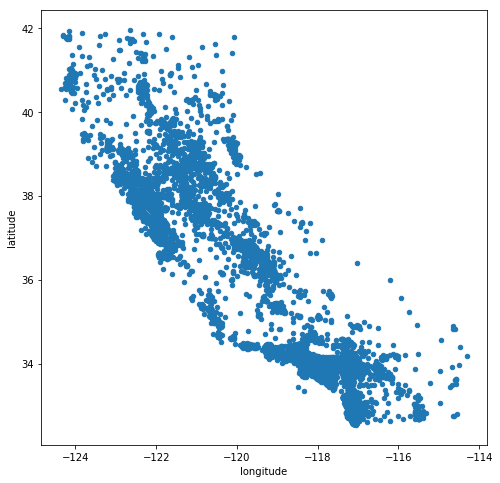

In [14]:
plt.rcParams["figure.figsize"] = [8.0, 8.0]
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude")
plt.show()

Pandas plots have lots of options for tailoring the output.  We can set an alpha value, so each point added is added with a fractional value.  Overlapping points then show up darker and darker.  

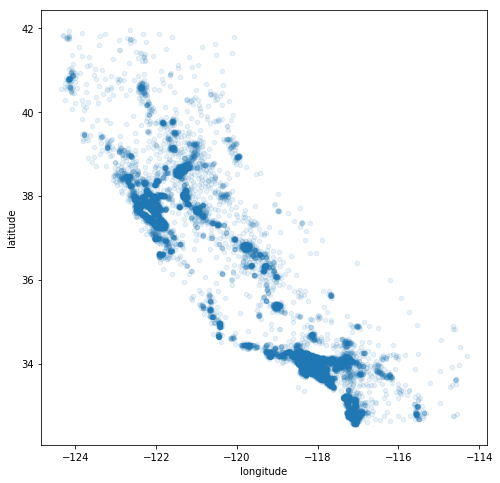

In [15]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

A much more complicated example.  We plot each point geogrpahically, and with a circle radius proportional to population, and a color indicating median income.  The get_cmap is a function that returns a color map.  The passed value is the name of a common one, from blue to red: "Jet".

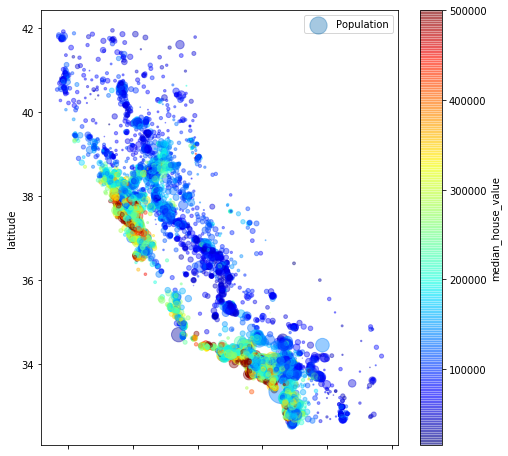

In [16]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/60, label="Population",
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()

## Reviewing Data

In [17]:
corr_matrix = housing.corr()
corr_median_value = corr_matrix["median_house_value"].sort_values(ascending=False)

In [18]:
print(corr_median_value)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64


We need to handle a few things in the data before we can move on.  

First, we need to acocmodate missing data.  There are some rows with missing values.  We need to fill these in.  The 'imputer' class provides a way to specify the handling of missing data.  We will use one to fill in the median value of income into any 'empty' cell.  

Second, we need to encode non numerical data.  We use 'one hot' encoding.  In this, each numerical value is treated as a binary field.  Only one of these fields will be hot at a time.  This avoids training relations between these values instead of using them individually as a predictor.


In [19]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [20]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [21]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

### Pipelines
We can combine all of the above into a single process, the pipeline.

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, LabelBinarizer

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6
    
class CombinedAttributesAdder():
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household      = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else: 
            return np.c_[X, rooms_per_household, population_per_household]
    
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('atrribs_adder', CombinedAttributesAdder(add_bedrooms_per_room=True)),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizer())
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [23]:
housing_prepared.shape

(16512, 16)